In [95]:
import networkx as nx
import copy
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import folium
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from osmnx.save_load import graph_to_gdfs
import os
#from torch_geometric.utils import from_networkx
#from torch_geometric.data import Data, DataLoader
#import torch

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

# Overview

1) Given a city, loads speed data and downloads the street network covering the appropriate area, and merge the data to save as a street network graph in graphML format in `/experiments/graphs`.

2) Converts street networks in `/experiments/graphs` to line graphs in `/experiments/line_graphs`.

## Configure

In [110]:
run_label = "san_francisco"

In [111]:
config = pd.DataFrame({"label": ["san_francisco"],
                       "address": ["San Francisco, California, USA"],
                       "buffer": [10000]})

config.set_index("label", inplace=True)

In [113]:
assert run_label in config.index
config

,address,buffer
label,,
san_francisco,"San Francisco, California, USA",10000


In [115]:
# movement data
movement_data_dir = "./data/movement_data/"
quarterly_data_fname = "movement-speeds-quarterly-by-hod-" + run_label.replace('_', '-') + "-2019-Q2.csv.zip"
assert os.path.isfile(movement_data_dir + quarterly_data_fname)

## Load Movement Data

In [116]:
%time df_raw = pd.read_csv(movement_data_dir + quarterly_data_fname, engine='c', compression='zip')

CPU times: user 7.36 s, sys: 272 ms, total: 7.63 s
Wall time: 7.63 s


In [117]:
df = df_raw
print("Rows in data: {}".format(len(df)))
df = df[(df['year'] == 2019) &
        (df['quarter'] == 2) &
        (df['hour_of_day'] == 12)]
print("Rows in day data: {}".format(len(df)))

Rows in data: 5474129
Rows in day data: 253627


## Download Graph

In [118]:
%time G = ox.graph_from_place(city_address, network_type='drive', simplify=True, name=city_label, buffer_dist=10000)

CPU times: user 42.8 s, sys: 156 ms, total: 42.9 s
Wall time: 42.9 s


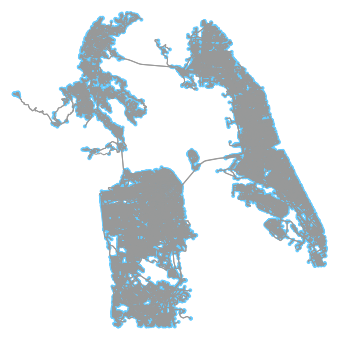

San Francisco, California, USA


In [119]:
ox.plot_graph(G)
print(G.graph['name'])

In [120]:
print(G.number_of_nodes())
print(G.number_of_edges())

32074
85223


## Join Data

In [121]:
# osmid column has multiple ids for some roads, this puts single
# ids in a list so that the column has uniform "type" [Int]
def make_uniform_osmid(ids):
    if type(ids) == int:
        return [ids]
    else:
        return ids
    
# lanes are repr as strs and lists of strs, this makes them
# all a single integer representing the max number of lanes
def make_uniform_lanes(lanes):
    if type(lanes) == list:
        return np.mean([float(l) for l in lanes])
    else:
        return float(lanes)
    
def parse_maxspeed(speed):
    if type(speed) == str:
        if speed[-4:] == ' mph':
            return float(speed[:-4])
    return np.NaN
    
gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
gdf_edges['osmid'] = gdf_edges['osmid'].map(make_uniform_osmid)
gdf_edges['lanes'] = gdf_edges['lanes'].map(make_uniform_lanes)
gdf_edges['maxspeed'] = gdf_edges['maxspeed'].map(parse_maxspeed)

### Inspect Node Overlap

In [122]:
nodes_in_data = set(df['osm_start_node_id']) | set(df['osm_end_node_id'])
print("Movement data for {} nodes".format(len(nodes_in_data)))
nodes_in_graph = set(gdf_nodes['osmid'])
print("Graph data for {} nodes".format(len(nodes_in_graph)))

Movement data for 158218 nodes
Graph data for 32074 nodes


In [123]:
print("intersection: {} ({})".format(len(nodes_in_data & nodes_in_graph),
                                     len(nodes_in_data & nodes_in_graph) / len(nodes_in_graph)))

intersection: 19658 (0.6128951798964893)


### Inspect Edge Overlap

In [124]:
edges_in_graph = set([e for es in gdf_edges['osmid'] for e in es])
print("Graph data for {} edges".format(len(edges_in_graph)))
edges_in_data = set(df['osm_way_id'])
print("Movement data for {} edges".format(len(edges_in_data)))

Graph data for 35423 edges
Movement data for 83662 edges


In [125]:
print("intersection: {} ({})".format(len(edges_in_data & edges_in_graph),
                                     len(edges_in_data & edges_in_graph) / len(edges_in_graph)))

intersection: 22747 (0.6421534031561414)


### Inspect Node Pairs Overlap

In [126]:
pairs_in_graph = set(list(zip(gdf_edges['u'], gdf_edges['v'])))
print("Graph data for {} pairs".format(len(pairs_in_graph)))
pairs_in_data = set(list(zip(df['osm_start_node_id'], df['osm_end_node_id'])))
print("Movement data for {} pairs".format(len(pairs_in_data)))

Graph data for 84613 pairs
Movement data for 253569 pairs


In [127]:
print("intersection: {} ({})".format(len(pairs_in_data & pairs_in_graph),
                                     len(pairs_in_data & pairs_in_graph) / len(pairs_in_graph)))

intersection: 27333 (0.3230354673631711)


### Join Data on Edge Overlaps

In [128]:
# expand graph edges dataframe w/ one osmid per row
# note call to DataFrame since explode doesn't seem to work with GeoDataFrame
gdf_expanded_edges = pd.DataFrame(gdf_edges).explode('osmid')

In [129]:
# merge on osm way ids
gdf_expanded_edges_merged = gdf_expanded_edges.merge(
    df,
    left_on='osmid',
    right_on='osm_way_id',
    how='left')

# take means across duplicate edges
gdf_edges_merged = gdf_expanded_edges_merged.groupby(
    ['u', 'v', 'key']).mean().reset_index()

# merge speeds back into original edge data
gdf_edges_merged = gdf_edges.merge(
    gdf_edges_merged[['u', 'v', 'key',
                      'speed_mph_mean',
                      'speed_mph_stddev',
                      'speed_mph_p50',
                      'speed_mph_p85']],
    on=['u', 'v', 'key'],
    validate='one_to_one')

In [130]:
gdf_edges_merged.shape

(85223, 23)

In [131]:
gdf_edges.shape

(85223, 19)

In [132]:
print("{}/{} ({}) edges have speed data".format(
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum(),
    len(gdf_edges_merged['speed_mph_mean']),
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum() / len(gdf_edges_merged['speed_mph_mean'])))

49501/85223 (0.5808408528214214) edges have speed data


## Rebuild Graph and Examine

In [133]:
G = ox.save_load.gdfs_to_graph(gdf_nodes, gdf_edges_merged)

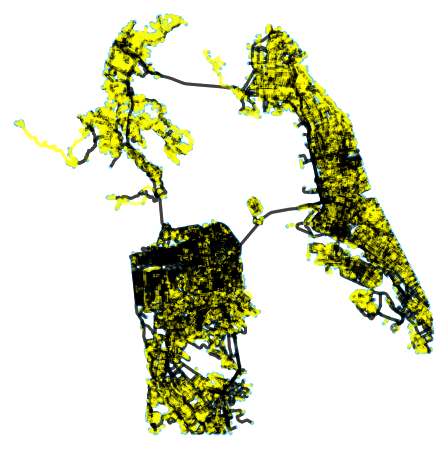

In [134]:
ec = ['black' if 'speed_mph_mean' in d.keys() else 'yellow' for (u,v,d) in G.edges(data=True)]
#ez = [3 if 'speed_mph_mean' in d.keys() else 4 for (u,v,d) in G.edges(data=True)]

fig, ax = ox.plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=0.5)

## Save Street Graph

In [135]:
ox.save_graphml(G, filename = city_label + ".graphml", folder="./experiments/graphs")

## Create Line Graph